In [0]:
import keras
import tensorflow.keras as tf
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior() 

import pandas as pd
import numpy as np
from pandas import read_csv
from pandas import concat
#from pandas import datetime
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
from datetime import datetime
import math

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense, LSTM

from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from mpl_toolkits import mplot3d


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### To upload file from Google drive to Colab ###

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
path = "/content/drive/My Drive/Colab Notebooks/CANDY_CANE_101.xlsx"
df = pd.read_excel(path)

### Upload file from local ###

In [0]:
df = pd.read_excel('C:/Users/Tokyo/Desktop/MSDS/Math6397 Case Studies/CANDY_CANE_101.xlsx')

### Preprocessing of raw file ###

In [0]:
duplicate_rows_df=df[df.duplicated()]  # check for duplicates
duplicate_rows_df.shape
df.columns =  ['Type','Name', 'Timestamp', 'CasePA','CasePB','FLP','FLT','Vol','TubP']

print(df.isnull().sum())

df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.drop(columns = ['Type','Name'])

# coerce values to float, otherwise fill with na
df['CasePA'] = pd.to_numeric(df['CasePA'], errors='coerce').astype(float)
df['CasePB'] = pd.to_numeric(df['CasePB'], errors='coerce').astype(float)
df['FLP'] = pd.to_numeric(df['FLP'], errors='coerce').astype(float)
df['FLT'] = pd.to_numeric(df['FLT'], errors='coerce').astype(float)
df['Vol'] = pd.to_numeric(df['Vol'], errors='coerce').astype(float)
df['TubP'] = pd.to_numeric(df['TubP'], errors='coerce').astype(float)

# Fill data for CasePB when missing. Use rolling 2 day rolling window
df['CasePB'] = df['CasePB'].fillna(df['TubP'].rolling(window = 2880).mean())

#Fill na with column means
df['CasePA'] = df['CasePA'].fillna(df['CasePA'].mean())
df['CasePB'] = df['CasePB'].fillna(df['CasePB'].mean())
df['FLP'] = df['FLP'].fillna(df['FLP'].mean())
df['FLT'] = df['FLT'].fillna(df['FLT'].mean())
df['Vol'] = df['Vol'].fillna(df['Vol'].mean())
df['TubP'] = df['TubP'].fillna(df['TubP'].mean())



Type              0
Name              0
Timestamp         0
CasePA            0
CasePB       422314
FLP               0
FLT               0
Vol               0
TubP              0
dtype: int64


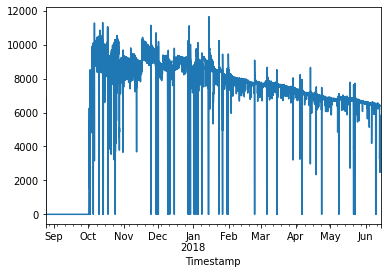

In [0]:
#set index name, initial plot
df.index.name = 'Timestamp'
df.set_index('Timestamp')['Vol'].plot()

62666


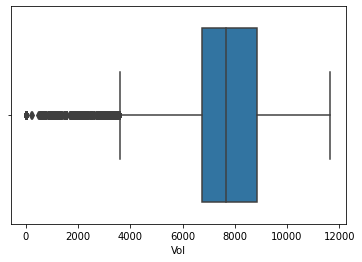

In [0]:
#QC outliers
sns.boxplot(x=df['Vol'])
iqr = df['Vol'].quantile(.75)-df['Vol'].quantile(.25)
outlier = 1.5*iqr
outlier

count = 0
for i in df['Vol']:
    if i <outlier:
        count += 1
print(count)

In [0]:
#Identify where volume = 0
PM = []

for i in df['Vol']:
    if i == 0:
        PM.append(1)
    else:
        PM.append(0)
df['PM'] = PM

In [0]:
df = df[(df[['PM']] == 0).all(axis=1)]  # Remove Volume = 0

In [0]:
df = df[(df[['CasePA']] >= 0).all(axis=1)]  # Remove bad sensor data
df = df[(df[['CasePB']] >= 0).all(axis=1)]  # Remove bad sensor data
df = df[(df[['FLP']] >= 0).all(axis=1)]  # Remove bad sensor data
df = df[(df[['FLT']] >= 0).all(axis=1)]  # Remove bad sensor data
df = df[(df[['Vol']] >= 0).all(axis=1)]  # Remove bad sensor data


In [0]:
df = df.drop(['PM'],axis = 1)

### Import Preprocessed LSTM dataset from Google drive ###

In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#path = "/content/drive/My Drive/CANDY_CANE_LSTM_Input.csv"
#df = pd.read_csv(path)
df.head()

,Timestamp,CasePA,CasePB,FLP,FLT,Vol,TubP
Timestamp,,,,,,,
0,2017-08-24 16:58:00,1702.092165,974.964683,542.902226,52.348799,6830.762999,971.477766
1,2017-08-24 16:59:00,1702.092165,974.964683,542.902226,52.348799,6830.762999,971.477766
2,2017-08-24 17:00:00,1702.092165,974.964683,542.902226,52.348799,6830.762999,971.477766
3,2017-08-24 17:01:00,1702.092165,974.964683,542.902226,52.348799,6830.762999,971.477766
4,2017-08-24 17:02:00,1702.092165,974.964683,542.902226,52.348799,6830.762999,971.477766


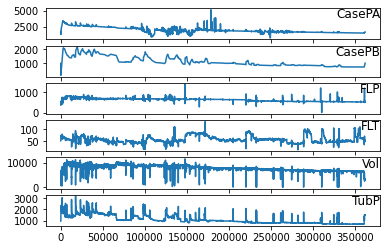

In [0]:
#df = df.drop(['Timestamp'],axis=1)  
#df = df.rename(columns={'Timestamp.1':'Timestamp'})
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# specify columns to plot
values = df.values
groups = [1, 2, 3, 4, 5, 6]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(df.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()



### Select working dataframe i.e. one month or one year ###

In [0]:
### Jan 2018 ###
#df = df[df['Timestamp'].dt.year >= 2018]  
#df = df[df['Timestamp'].dt.month < 2]

### 2018 ###
df = df[df['Timestamp'].dt.year >= 2018]  

df = df.set_index('Timestamp')

df.head()


,CasePA,CasePB,FLP,FLT,Vol,TubP
Timestamp,,,,,,
2018-01-01 00:00:00,2070.508057,1326.526569,648.307800,41.032509,8538.653320,1271.876099
2018-01-01 00:01:00,2070.637695,1326.473592,667.404175,41.602646,8496.515625,1271.616821
2018-01-01 00:02:00,2070.637695,1326.420614,667.404175,41.602646,8496.515625,1271.616821
2018-01-01 00:03:00,2070.637695,1326.367636,667.404175,41.602646,8496.515625,1271.616821
2018-01-01 00:04:00,2070.637695,1326.314659,667.404175,41.602646,8496.515625,1271.616821


In [0]:
df.shape

(232768, 6)

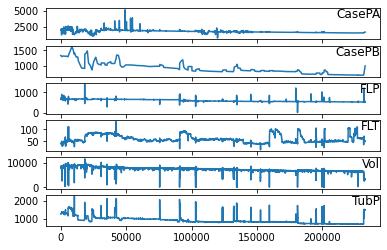

In [0]:
# specify columns to plot
values = df.values
groups = [0, 1, 2, 3, 4, 5]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(df.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [0]:
### Select Variables for analysis ###

df_casePA = df.iloc[:,0]
df_casePB = df.iloc[:,1]
df_flp = df.iloc[:,2]
df_flt = df.iloc[:,3]
df_tub = df.iloc[:,5]
df_vol = df.iloc[:,4]
#frame = [df_casePA, df_casePB, df_flp, df_flt, df_tub, df_vol] ## all variables
frame = [df_flp, df_vol] ### flow line pressure as predictor variable

df_volume = pd.DataFrame(frame).T
df_volume.head()

,FLP,Vol
Timestamp,,
2018-01-01 00:00:00,648.307800,8538.653320
2018-01-01 00:01:00,667.404175,8496.515625
2018-01-01 00:02:00,667.404175,8496.515625
2018-01-01 00:03:00,667.404175,8496.515625
2018-01-01 00:04:00,667.404175,8496.515625


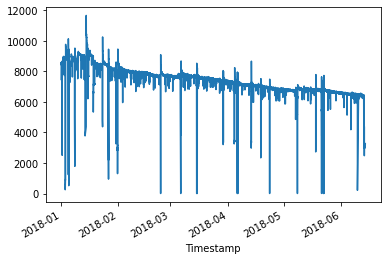

In [0]:
#df_volume.index.name = 'Timestamp'
#df_volume.set_index('Timestamp')['Vol'].plot()

df_volume['Vol'].plot()

### Prepare dataframe for time series learning ###

In [0]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


In [0]:
a = series_to_supervised(df_volume, 5, 1 )
a.head(1)

,var1(t-5),var2(t-5),var1(t-4),var2(t-4),var1(t-3),var2(t-3),var1(t-2),var2(t-2),var1(t-1),var2(t-1),var1(t),var2(t)
Timestamp,,,,,,,,,,,,
2018-01-01 00:05:00,648.3078,8538.65332,667.404175,8496.515625,667.404175,8496.515625,667.404175,8496.515625,667.404175,8496.515625,667.404175,8496.515625


In [0]:
values = df_volume.values

## integer encode direction
#encoder = LabelEncoder()
#values[:,5] = encoder.fit_transform(values[:,5])

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))  ### default activation function in LSTM is tanh ###
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 15, 1)  ### specify how many minutes to look back ###
# drop columns we don't want to predict
reframed.drop(reframed.columns[-2], axis=1, inplace=True)  ### drop columns dependent on number of variables ###
reframed.head()

,var1(t-15),var2(t-15),var1(t-14),var2(t-14),var1(t-13),var2(t-13),var1(t-12),var2(t-12),var1(t-11),var2(t-11),var1(t-10),var2(t-10),var1(t-9),var2(t-9),var1(t-8),var2(t-8),var1(t-7),var2(t-7),var1(t-6),var2(t-6),var1(t-5),var2(t-5),var1(t-4),var2(t-4),var1(t-3),var2(t-3),var1(t-2),var2(t-2),var1(t-1),var2(t-1),var2(t)
15,-0.057326,0.464873,-0.029542,0.457643,-0.029542,0.457643,-0.029542,0.457643,-0.029542,0.457643,-0.029542,0.457643,-0.029542,0.457643,-0.029542,0.457643,-0.029542,0.457643,-0.029542,0.457643,-0.029542,0.457643,-0.029542,0.457643,-0.029542,0.457643,-0.029542,0.457643,-0.029542,0.457643,0.458316
16,-0.029542,0.457643,-0.029542,0.457643,-0.029542,0.457643,-0.029542,0.457643,-0.029542,0.457643,-0.029542,0.457643,-0.029542,0.457643,-0.029542,0.457643,-0.029542,0.457643,-0.029542,0.457643,-0.029542,0.457643,-0.029542,0.457643,-0.029542,0.457643,-0.029542,0.457643,-0.023913,0.458316,0.459196
17,-0.029542,0.457643,-0.029542,0.457643,-0.029542,0.457643,-0.029542,0.457643,-0.029542,0.457643,-0.029542,0.457643,-0.029542,0.457643,-0.029542,0.457643,-0.029542,0.457643,-0.029542,0.457643,-0.029542,0.457643,-0.029542,0.457643,-0.029542,0.457643,-0.023913,0.458316,-0.016552,0.459196,0.459196
18,-0.029542,0.457643,-0.029542,0.457643,-0.029542,0.457643,-0.029542,0.457643,-0.029542,0.457643,-0.029542,0.457643,-0.029542,0.457643,-0.029542,0.457643,-0.029542,0.457643,-0.029542,0.457643,-0.029542,0.457643,-0.029542,0.457643,-0.023913,0.458316,-0.016552,0.459196,-0.016552,0.459196,0.459196
19,-0.029542,0.457643,-0.029542,0.457643,-0.029542,0.457643,-0.029542,0.457643,-0.029542,0.457643,-0.029542,0.457643,-0.029542,0.457643,-0.029542,0.457643,-0.029542,0.457643,-0.029542,0.457643,-0.029542,0.457643,-0.023913,0.458316,-0.016552,0.459196,-0.016552,0.459196,-0.016552,0.459196,0.459196


###**Basic Architecture**


(129600, 1, 30) (129600,) (103153, 1, 30) (103153,)
Train on 129600 samples, validate on 103153 samples
Epoch 1/25
 - 4s - loss: 0.0036 - val_loss: 4.0654e-04
Epoch 2/25
 - 4s - loss: 6.5391e-04 - val_loss: 3.5516e-04
Epoch 3/25
 - 4s - loss: 6.4134e-04 - val_loss: 3.3677e-04
Epoch 4/25
 - 4s - loss: 5.3309e-04 - val_loss: 4.1477e-04
Epoch 5/25
 - 4s - loss: 4.9084e-04 - val_loss: 6.2899e-04
Epoch 6/25
 - 4s - loss: 4.7611e-04 - val_loss: 8.3660e-04
Epoch 7/25
 - 4s - loss: 4.3937e-04 - val_loss: 7.7125e-04
Epoch 8/25
 - 4s - loss: 4.5537e-04 - val_loss: 0.0010
Epoch 9/25
 - 4s - loss: 3.9347e-04 - val_loss: 3.3188e-04
Epoch 10/25
 - 4s - loss: 4.7846e-04 - val_loss: 8.1303e-04
Epoch 11/25
 - 4s - loss: 3.6019e-04 - val_loss: 3.2589e-04
Epoch 12/25
 - 4s - loss: 4.6971e-04 - val_loss: 5.9213e-04
Epoch 13/25
 - 4s - loss: 3.4120e-04 - val_loss: 3.1510e-04
Epoch 14/25
 - 4s - loss: 4.4949e-04 - val_loss: 4.7549e-04
Epoch 15/25
 - 4s - loss: 3.2773e-04 - val_loss: 3.9534e-04
Epoch 16/25
 

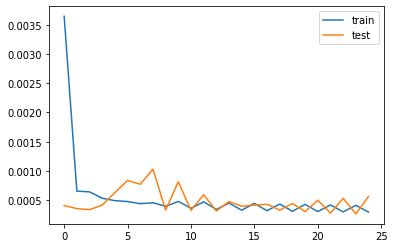

In [0]:
values = reframed.values

### One Month ###
#n_train_minutes = 60 * 24 * 7   #10,080 minutes
#train = values[:n_train_minutes, :]
#test = values[n_train_minutes:, :]

### One Year ###
n_train_minutes = 60 * 24 * 90   #129,600 minutes
train = values[:n_train_minutes, :]
test = values[n_train_minutes:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

#design architecture
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=25, batch_size=100, validation_data=(test_X, test_y), verbose=2, shuffle=False)
score = model.evaluate(test_X, test_y, batch_size=100)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [0]:
score

0.0005627648722230518

### Inverse Scaling ###

In [0]:
index = test_X.shape[2]-1
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))


# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, index:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, index:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 16.305


### **Different Architecture**



(129600, 1, 30) (129600,) (103153, 1, 30) (103153,)
Train on 129600 samples, validate on 103153 samples
Epoch 1/25
 - 4s - loss: 0.0050 - val_loss: 9.6259e-04
Epoch 2/25
 - 4s - loss: 0.0023 - val_loss: 6.4878e-04
Epoch 3/25
 - 4s - loss: 0.0017 - val_loss: 3.5929e-04
Epoch 4/25
 - 4s - loss: 0.0014 - val_loss: 3.2014e-04
Epoch 5/25
 - 4s - loss: 0.0012 - val_loss: 8.7054e-04
Epoch 6/25
 - 4s - loss: 0.0011 - val_loss: 5.0060e-04
Epoch 7/25
 - 4s - loss: 0.0011 - val_loss: 8.1061e-04
Epoch 8/25
 - 4s - loss: 0.0011 - val_loss: 4.6961e-04
Epoch 9/25
 - 4s - loss: 8.9663e-04 - val_loss: 9.3248e-04
Epoch 10/25
 - 4s - loss: 0.0011 - val_loss: 4.0960e-04
Epoch 11/25
 - 4s - loss: 9.4506e-04 - val_loss: 9.2838e-04
Epoch 12/25
 - 4s - loss: 8.4530e-04 - val_loss: 3.2436e-04
Epoch 13/25
 - 4s - loss: 0.0011 - val_loss: 6.6647e-04
Epoch 14/25
 - 4s - loss: 9.4093e-04 - val_loss: 3.5838e-04
Epoch 15/25
 - 4s - loss: 0.0010 - val_loss: 6.9297e-04
Epoch 16/25
 - 4s - loss: 7.8138e-04 - val_loss: 

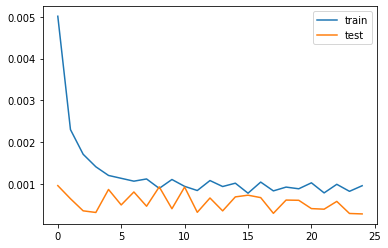

In [0]:
values = reframed.values

### One Month ###
#n_train_minutes = 60 * 24 * 7   #10,080 minutes
#train = values[:n_train_minutes, :]
#test = values[n_train_minutes:, :]

### One Year ###
n_train_minutes = 60 * 24 * 90   #129,600 minutes
train = values[:n_train_minutes, :]
test = values[n_train_minutes:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
#model.add(LSTM(128))
model.add(keras.layers.Dropout(0.5))
#model.add(Dense(1, activation='sigmoid'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=25, batch_size=100, validation_data=(test_X, test_y), verbose=2, shuffle=False)
score = model.evaluate(test_X, test_y, batch_size=100)

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [0]:
score

0.00028564425655102824

In [0]:
score

0.00028564425655102824

In [0]:
index = test_X.shape[2]-1
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))


# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, index:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, index:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 11.616
